In [1]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
class MCVDDataset(Dataset):

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.mcvd_data = pd.read_csv(csv_file)

    def __len__(self):
        return self.mcvd_data.shape[0]

    def __getitem__(self, idx):
        
        data = self.mcvd_data.iloc[idx][5:].values.astype('float32')
        target = (self.mcvd_data.iloc[idx][1])
        sample = {'data': data, 'target': target}

        return sample

In [3]:
def build_references(df):
    productids = df['prodid'].unique()
    #prepare dataframe
    result = pd.DataFrame()
    
    # get column order
    columns = ['prodid']
    [columns.append(x) for x in df.iloc[:,6:].columns]
    # select curves of interreste
    references = df.loc[df['adjustment'] == 0]
    
    for productid in productids:
        
        if len(references.loc[references['prodid'] == productid]) >1: 
            reference = references.loc[references['prodid'] == productid].iloc[:,6:].median()
        
        else:
            reference = references.loc[references['prodid'] == productid].iloc[0,6:]

        S = pd.Series({'prodid': productid}).append(reference)

        result = result.append(S,ignore_index=True)
        
        
    return result[columns]
        
        

In [4]:
def substract_reference(df,references):
    
    prodids = df['prodid'].unique()
    
    for prodid in prodids:
        ref = references.loc[references['prodid'] == prodid].iloc[:,1:].values
        n_samples = df.loc[df['prodid'] == prodid].shape[0]

        array = np.empty((n_samples,300))
        for i in range(n_samples):
            array[i] = ref


        df.loc[df['prodid'] == prodid,'0':] = df.loc[df['prodid'] == prodid].iloc[:,6:] - array
    
            
            
    return df

In [5]:
m21 = MCVDDataset(csv_file='m21-dataset-clean.csv')
m21.mcvd_data = m21.mcvd_data.drop('Unnamed: 0',axis=1)
m21.mcvd_data.insert(1,'adjustment',(m21.mcvd_data ['targetval']- m21.mcvd_data ['val']))
m21.mcvd_data.insert(0,'machine','m21')


m22 = MCVDDataset(csv_file='m22-dataset-clean.csv')
m22.mcvd_data = m22.mcvd_data.drop('Unnamed: 0',axis=1)
m22.mcvd_data.insert(1,'adjustment',(m22.mcvd_data ['targetval']- m22.mcvd_data ['val']))
m22.mcvd_data.insert(0,'machine','m22')

m24 = MCVDDataset(csv_file='m24-dataset-clean.csv')
m24.mcvd_data = m24.mcvd_data.drop('Unnamed: 0',axis=1)
m24.mcvd_data.insert(1,'adjustment',(m24.mcvd_data ['targetval']- m24.mcvd_data ['val']))
m24.mcvd_data.insert(0,'machine','m24')

m25 = MCVDDataset(csv_file='m25-dataset-clean.csv')
m25.mcvd_data = m25.mcvd_data.drop('Unnamed: 0',axis=1)
m25.mcvd_data.insert(1,'adjustment',(m25.mcvd_data ['targetval']- m25.mcvd_data ['val']))
m25.mcvd_data.insert(0,'machine','m25')

All = MCVDDataset(csv_file='all-data.csv')
All.mcvd_data = All.mcvd_data.drop('Unnamed: 0',axis=1)


datasets = [m21, m22, m24, m25]

# Generating datasets

In [121]:
machine = 'm25'
targets = pd.read_csv('{}-targetdata-dataset.csv'.format(machine.upper()))
references =  pd.read_csv('{}-refdata-dataset.csv'.format(machine.upper()))
print(targets.shape)

(116, 305)


In [122]:
mask  = references['prodid'] != -1

targets = targets[mask].reset_index(drop=True)
references = references[mask].reset_index(drop=True)
print(targets.shape)

(114, 305)


In [123]:
references.shape

(114, 305)

In [124]:
targets.iloc[:,5:] = targets.iloc[:,5:] - references.iloc[:,5:]

In [125]:
targets = targets.dropna()
targets = targets.drop('Unnamed: 0',axis=1)
targets.insert(1,'adjustment',(targets['targetval']- targets ['val']))
#targets = pd.concat([targets,pd.get_dummies(targets['prodid'])],axis=1)
#m21.mcvd_data.insert(1,'adjustment',(m21.mcvd_data ['targetval']- m21.mcvd_data ['val']))

In [126]:
targets.to_csv('{}-test-dataset.csv'.format(machine.upper()))

# generating final dataset

In [130]:
machines = ['m21', 'm22', 'm24', 'm25']
machine = machines[0]
df = pd.read_csv('{}-test-dataset.csv'.format(machine.upper()))
df = df.drop('Unnamed: 0',axis=1)
df.insert(0,'machine',machine)

for machine in machines[1:]:
    
    df2 = pd.read_csv('{}-test-dataset.csv'.format(machine.upper()))
    df2 = df2.drop('Unnamed: 0',axis=1)
    df2.insert(0,'machine',machine)
    
    df = df.append(df2,ignore_index=True)
    

In [137]:
df2 = pd.concat([df,pd.get_dummies(df['machine'])],axis=1)
df2 = pd.concat([df,pd.get_dummies(df['prodid'])],axis=1)

In [139]:
df2.to_csv('goldentest.csv')

In [132]:
df2

,machine,prodid,adjustment,targetval,val,starttime,0,1,2,3,...,295,296,297,298,299,prodid,machine_m21,machine_m22,machine_m24,machine_m25
0,m21,9945,0.020,0.540,0.520,2018-12-04 04:25:43,-53.601624,-62.036743,-62.636780,-60.588013,...,19.854248,23.854614,30.002808,35.228882,42.495239,9945,1,0,0,0
1,m21,9945,0.010,0.520,0.510,2018-11-30 20:40:19,34.628601,46.392334,56.211182,68.890991,...,-75.070435,-77.774658,-76.416626,-75.751587,-77.167236,9945,1,0,0,0
2,m21,9945,0.010,0.510,0.500,2018-11-29 01:29:17,-25.371094,-14.726440,-7.851501,-10.131592,...,-31.526123,-26.457397,-17.132812,-5.828857,6.585327,9945,1,0,0,0
3,m21,9945,0.010,0.500,0.490,2018-11-21 11:35:42,13.949646,-4.225586,-22.716370,-41.313416,...,-62.925537,-67.886108,-67.797974,-61.801514,-50.567139,9945,1,0,0,0
4,m21,9945,0.050,0.490,0.440,2018-11-13 08:37:40,-189.076416,-174.474792,-157.645996,-143.587097,...,-45.805786,-42.742920,-37.498779,-38.045410,-44.107056,9945,1,0,0,0
5,m21,9305,-0.010,0.610,0.620,2018-08-23 15:10:38,15.173218,16.276611,14.864624,15.947632,...,17.713867,18.257812,18.077026,18.029663,17.744385,9305,1,0,0,0
6,m21,9305,0.040,0.620,0.580,2018-08-23 10:48:54,-6.429321,-6.641785,-7.198059,-5.239868,...,10.510498,10.324463,10.475586,10.233765,10.407715,9305,1,0,0,0
7,m21,9305,0.030,0.580,0.550,2018-08-17 15:02:44,-4.464417,-6.168701,-6.728577,-5.163391,...,-8.612183,-8.942627,-8.687378,-8.411865,-8.253906,9305,1,0,0,0
8,m21,9305,0.005,0.540,0.535,2018-08-14 06:45:32,3.272766,4.577820,4.432800,2.053345,...,4.820923,4.959839,4.714844,4.642578,4.429932,9305,1,0,0,0
9,m21,9305,0.005,0.535,0.530,2018-08-13 14:10:59,2.358643,1.898376,1.493103,0.973083,...,-1.330811,-1.404297,-1.179199,-1.239990,-0.759888,9305,1,0,0,0


In [ ]:
def substract_reference(df,references):
    
    prodids = df['prodid'].unique()
    
    for prodid in prodids:
        ref = references.loc[references['prodid'] == prodid].iloc[:,1:].values
        n_samples = df.loc[df['prodid'] == prodid].shape[0]

        array = np.empty((n_samples,300))
        for i in range(n_samples):
            array[i] = ref


        df.loc[df['prodid'] == prodid,'0':] = df.loc[df['prodid'] == prodid].iloc[:,6:] - array
    
            
            
    return df

In [116]:
df = pd.DataFrame(columns = ['machine', 'adjustment', 'prodid', 'starttime',
       'targetval', 'val'])
for dataset in datasets:
    df = df.append(dataset.mcvd_data,ignore_index=True)
    columns = dataset.mcvd_data.columns
    
df = df[columns]

df['starttime'] = pd.to_datetime(df['starttime'])



In [100]:
df2 = df.loc[df['prodid'] == 7391].reset_index(drop=True)
curves = df2.loc[df2['adjustment'] != 0].iloc[:,6:].values
refs = df2.loc[df2['adjustment'] == 0].iloc[:,6:].values

In [69]:
referenceids = df.loc[df['adjustment'] == 0]['prodid'].unique()
df = df.loc[df['prodid'].isin(referenceids)].reset_index(drop=True)

In [70]:
references = build_references(df)
df = df[df['adjustment'] != 0]

df = substract_reference(df,references)

In [30]:
df.to_csv('dataset.csv')

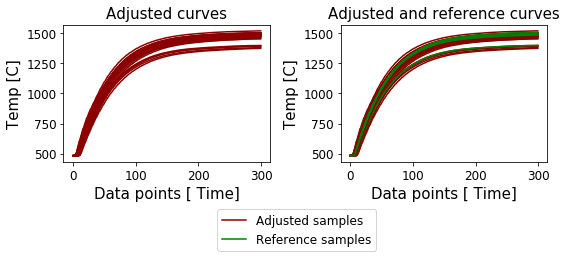

In [71]:
f, axes = plt.subplots(1,2,figsize=(8,3))

custom_lines = [Line2D([0], [0], color='darkred'),
                Line2D([0], [0], color='green')]


axes[0].plot(curves.T,color='darkred')
axes[0].set_xlabel("Data points [ Time]",size=15)
axes[0].set_ylabel("Temp [C]",size=15)
axes[0].set_title('Adjusted curves',size=15)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].yaxis.set_tick_params(labelsize=12)

for ref,curve in zip(refs,curves):
    axes[1].plot(curve,color='darkred');
    axes[1].plot(ref,color='green');
    

axes[1].set_xlabel("Data points [ Time]",size=15)
axes[1].set_ylabel("Temp [C]",size=15)
axes[1].set_title('Adjusted and reference curves',size=15)
axes[1].xaxis.set_tick_params(labelsize=12)
axes[1].yaxis.set_tick_params(labelsize=12)

axes[1].legend(custom_lines, ['Adjusted samples', 'Reference samples'],bbox_to_anchor=(0.2, -0.3),fontsize='large')
plt.tight_layout()
plt.show()
f.savefig("adjVSref.pdf", bbox_inches='tight')

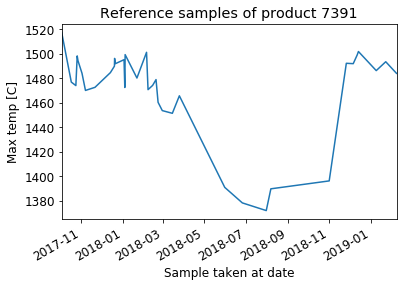

In [106]:
ax = df2.loc[df2['adjustment'] != 0].set_index('starttime').max(axis=1).plot(fontsize='large')
plt.xlabel("Sample taken at date",size='large')
plt.ylabel("Max temp [C]",size='large')
plt.title('Reference samples of product 7391',size='x-large')
plt.show()
f = ax.get_figure()
f.savefig('refMax.pdf')

In [83]:
a = df2.iloc[:,6:].values
df2.iloc[:,6:] = zscale(a, mean, std)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


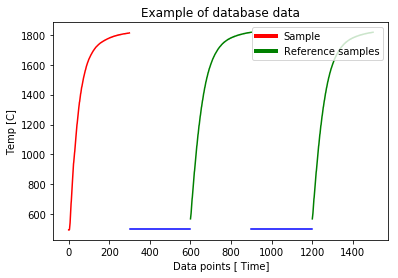

In [56]:
slicei = 300
zeroes = 300
a = np.empty(zeroes)
a.fill(500)
array = data.iloc[1,5:].values
array = np.append(array,a)
array = np.append(array,data.iloc[85,5:].values)

f = plt.figure()
plt.plot(array[:slicei],'r')
plt.plot(np.arange(slicei,slicei+zeroes),array[slicei:slicei+zeroes],'b')
plt.plot(np.arange(slicei+zeroes,len(array)),array[slicei+zeroes:],'g')
plt.plot(np.arange((slicei+slicei+zeroes),slicei+zeroes+slicei+zeroes),array[slicei:slicei+zeroes],'b')
plt.plot(np.arange(slicei+zeroes+slicei+zeroes,len(array)+slicei+zeroes),array[slicei+zeroes:],'g')
plt.xlabel("Data points [ Time]")
plt.ylabel("Temp [C]")
plt.title('Example of database data')
legend_elements = [Line2D([0], [0], color='r', lw=4, label='Sample'),
                   Line2D([0], [0], color='g', lw =4, label = 'Reference samples')]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()
#f = ax.get_figure()
f.savefig("DB_Example.pdf", bbox_inches='tight')

# Comparing the datasets

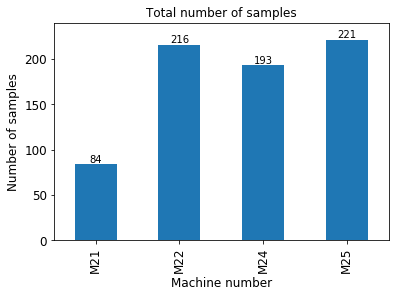

In [116]:
#plt.rcParams.update({'font.size': 12})
series = pd.Series((m21.mcvd_data.shape[0],m22.mcvd_data.shape[0],m24.mcvd_data.shape[0],m25.mcvd_data.shape[0]),index=['M21','M22','M24','M25'])
ax = series.plot(kind='bar',title="Total number of samples",fontsize='large')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(int(y)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

    
ax.set_xlabel("Machine number",size='large')
ax.set_ylabel("Number of samples",size='large')

plt.ylim(top=240)
plt.plot()
f = ax.get_figure()
f.savefig("n_samples.pdf", bbox_inches='tight')

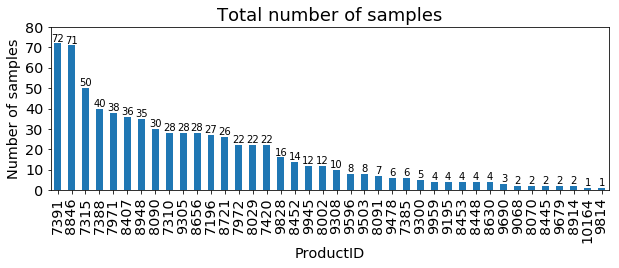

In [126]:
ax = df['prodid'].value_counts().plot(kind='bar',figsize=(10,3),fontsize='x-large')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{}'.format(int(y)), (x.mean(), y,),
    ha='center', va='bottom') # set the alignment of the text
    
ax.set_ylim(0,80)   
ax.set_xlabel("ProductID",size='x-large')
ax.set_ylabel("Number of samples",size='x-large')
ax.set_title("Total number of samples",size=18)
#plt.ylim(top=240)
plt.plot()
f = ax.get_figure()
f.savefig("n_prodids.pdf", bbox_inches='tight')

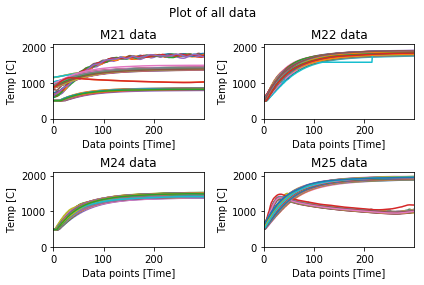

In [50]:
#plt.rcParams.update({'font.size': 16})fig, axes = plt.subplots(2, 2,figsize=(10,8))
fig, axes = plt.subplots(2, 2,figsize=(10,6))
m21.mcvd_data.iloc[:,5:].T.plot(legend=None,title="M21 data",ax=axes[0,0])
axes[0,0].set_xlabel("Data points [Time]")
axes[0,0].set_ylabel("Temp [C]")
axes[0,0].set_ylim([0, 2100])

m22.mcvd_data.iloc[:,5:].T.plot(legend=None,title="M22 data",ax=axes[0,1])
axes[0,1].set_xlabel("Data points [Time]")
axes[0,1].set_ylabel("Temp [C]")
axes[0,1].set_ylim([0, 2100])

m24.mcvd_data.iloc[:,5:].T.plot(legend=None,title="M24 data",ax=axes[1,0])
axes[1,0].set_xlabel("Data points [Time]")
axes[1,0].set_ylabel("Temp [C]")
axes[1,0].set_ylim([0, 2100])

m25.mcvd_data.iloc[:,5:].T.plot(legend=None,title="M25 data",ax=axes[1,1])
axes[1,1].set_xlabel("Data points [Time]")
axes[1,1].set_ylabel("Temp [C]")
axes[1,1].set_ylim([0, 2100])

plt.suptitle("Plot of all data")
plt.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

fig.savefig("All_Data.pdf", bbox_inches='tight')

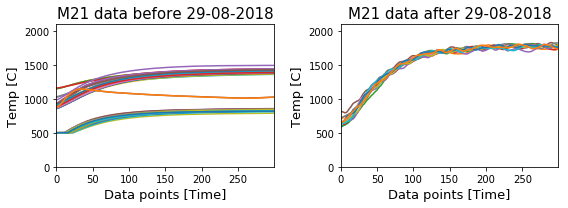

In [38]:
fig, axes = plt.subplots(1, 2,figsize=(8,3))

df.loc[(df['machine'] == 'm21') & (df['starttime'] > '2018-08-29')].iloc[:,6:].T.plot(legend=None,ax=axes[1])
axes[1].set_xlabel("Data points [Time]",size=13)
axes[1].set_ylabel("Temp [C]",size=13)
axes[1].set_ylim([0, 2100])
axes[1].set_title('M21 data after 29-08-2018',size=15)

df.loc[(df['machine'] == 'm21') & (df['starttime'] < '2018-08-29')].iloc[:,6:].T.plot(legend=None,ax=axes[0])
axes[0].set_xlabel("Data points [Time]",size=13)
axes[0].set_ylabel("Temp [C]",size=13)
axes[0].set_ylim([0, 2100])
axes[0].set_title('M21 data before 29-08-2018',size=15)

plt.tight_layout()

fig.savefig("m21-error.pdf", bbox_inches='tight')

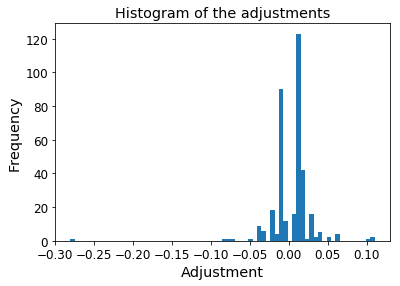

In [125]:
mask = (df['adjustment'] !=0)
ax = df.loc[mask]['adjustment'].hist(bins='fd',grid=False,)
ax.set_xlabel("Adjustment",size='x-large')
ax.set_ylabel("Frequency",size='x-large')
ax.set_title("Histogram of the adjustments",size='x-large')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()
f = ax.get_figure()
f.savefig("adj-hist.pdf", bbox_inches='tight')

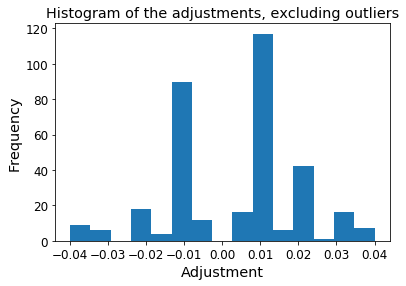

In [126]:
q1 = np.percentile(df.loc[mask]['adjustment'], 25)
q3 = np.percentile(df.loc[mask]['adjustment'], 75)
IQR = abs(q1-q3)

minlim = q1-(1.5*IQR)
maxlim = q3+(1.5*IQR)


mask = (minlim <= df['adjustment']) & (df['adjustment'] <=maxlim) & (df['adjustment'] !=0)
ax = df.loc[mask]['adjustment'].hist(bins='fd',grid=False)
#ax.set_xlim(minlim,maxlim)
ax.set_xlabel("Adjustment",size='x-large')
ax.set_ylabel("Frequency",size='x-large')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Histogram of the adjustments, excluding outliers",size='x-large')
f = ax.get_figure()
plt.show()
f.savefig("adj-hist-zoom.pdf", bbox_inches='tight')

In [127]:
df

,machine,prodid,adjustment,targetval,val,starttime,0,1,2,3,...,290,291,292,293,294,295,296,297,298,299
0,m21,9945,0.020,0.540,0.520,2018-12-04 04:25:43,592.815125,591.794617,595.602417,606.563354,...,1790.565918,1788.083496,1783.526733,1780.427246,1773.602051,1768.502075,1767.935303,1770.523560,1772.624023,1778.689697
1,m21,9945,0.010,0.520,0.510,2018-11-30 20:40:19,701.528198,709.587341,713.781921,722.543396,...,1731.326172,1728.975464,1727.023193,1726.315308,1724.901367,1724.786133,1725.746338,1729.077026,1733.856934,1736.765503
2,m21,9945,0.010,0.510,0.500,2018-11-29 01:29:17,607.899841,606.221619,605.999695,606.570679,...,1757.030762,1760.599487,1763.340576,1765.603027,1767.789307,1769.242676,1773.512939,1779.958496,1787.926025,1796.326294
3,m21,9945,0.010,0.500,0.490,2018-11-21 11:35:42,665.848755,655.410278,649.023926,637.917114,...,1731.382690,1730.123291,1728.766479,1728.005127,1727.681641,1727.692627,1728.848022,1731.632202,1736.013306,1741.925293
4,m21,9945,0.050,0.490,0.440,2018-11-13 08:37:40,632.212708,641.434509,653.968933,666.009827,...,1758.969482,1763.225220,1770.604858,1773.422363,1772.317871,1769.686279,1766.411255,1764.198730,1757.627441,1749.590332
5,m21,9945,0.060,0.530,0.470,2018-11-12 13:58:16,821.289124,815.909302,811.614929,809.596924,...,1831.338501,1828.398315,1824.820801,1821.406860,1819.663086,1815.492065,1809.154175,1801.697510,1795.672852,1793.697388
6,m21,9305,-0.010,0.610,0.620,2018-08-23 15:10:38,887.475525,890.554688,892.706116,898.171326,...,1418.445068,1418.187500,1418.335693,1418.507568,1418.695801,1418.842529,1419.211670,1419.386230,1419.503418,1419.656372
7,m21,9305,0.040,0.620,0.580,2018-08-23 10:48:54,872.302307,874.278076,877.841492,882.223694,...,1400.385132,1400.403564,1400.436035,1400.804199,1400.927368,1401.128662,1400.953857,1401.309204,1401.473755,1401.911987
8,m21,9305,0.030,0.580,0.550,2018-08-17 15:02:44,874.669250,875.488098,878.510132,882.386108,...,1378.355957,1378.374390,1378.382324,1378.382935,1378.565430,1378.809570,1378.946289,1379.373291,1379.720093,1379.997925
9,m21,9305,0.005,0.540,0.535,2018-08-14 06:45:32,884.907532,887.065063,890.313110,892.323608,...,1393.485107,1393.979858,1394.246216,1394.292114,1394.311279,1394.374146,1394.463745,1394.478149,1394.475342,1394.535889


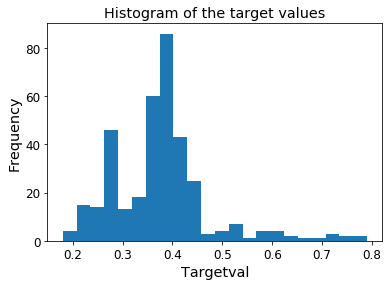

In [133]:
mask = (df['adjustment'] !=0)
ax = df.loc[mask]['targetval'].hist(bins='fd',grid=False,)
ax.set_xlabel("Targetval",size='x-large')
ax.set_ylabel("Frequency",size='x-large')
ax.set_title("Histogram of the target values",size='x-large')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()
f = ax.get_figure()
f.savefig("tar-hist.pdf", bbox_inches='tight')

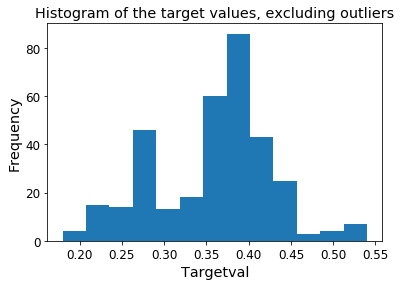

In [132]:
q1 = np.percentile(df.loc[mask]['targetval'], 25)
q3 = np.percentile(df.loc[mask]['targetval'], 75)
IQR = abs(q1-q3)

minlim = q1-(1.5*IQR)
maxlim = q3+(1.5*IQR)


mask = (minlim <= df['targetval']) & (df['targetval'] <=maxlim) & (df['adjustment'] !=0)
ax = df.loc[mask]['targetval'].hist(bins='fd',grid=False)
#ax.set_xlim(minlim,maxlim)
ax.set_xlabel("Targetval",size='x-large')
ax.set_ylabel("Frequency",size='x-large')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Histogram of the target values, excluding outliers",size='x-large')
f = ax.get_figure()
plt.show()
f.savefig("tar-hist-zoom.pdf", bbox_inches='tight')

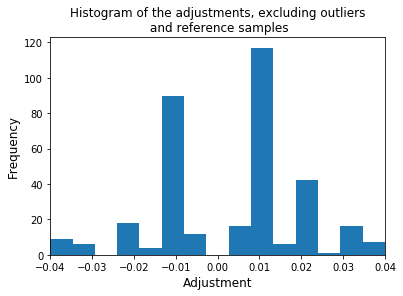

In [187]:
mask = (df['adjustment'] !=0)
q1 = np.percentile(df.loc[mask]['adjustment'], 25)
q3 = np.percentile(df.loc[mask]['adjustment'], 75)
IQR = abs(q1-q3)

minlim = q1-(1.5*IQR)
maxlim = q3+(1.5*IQR)


mask = (minlim <= df['adjustment']) & (df['adjustment'] <=maxlim) & (df['adjustment'] !=0)
ax = df.loc[mask]['adjustment'].hist(bins='fd',grid=False,)
ax.set_xlim(minlim,maxlim)
ax.set_xlabel("Adjustment",size='large')
ax.set_ylabel("Frequency",size='large')
ax.set_title("Histogram of the adjustments, excluding outliers\n and reference samples",size='large')
f = ax.get_figure()
plt.plot()
f.savefig("adj-hist-zoom-excl0.pdf", bbox_inches='tight')

# target values

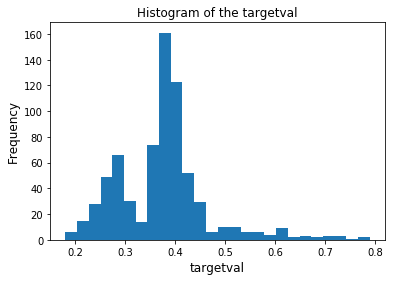

In [180]:
ax = df['targetval'].hist(bins='fd',grid=False,)
ax.set_xlabel("targetval",size='large')
ax.set_ylabel("Frequency",size='large')
ax.set_title("Histogram of the targetval",size='large')

plt.plot()
f = ax.get_figure()
f.savefig("tar-hist.pdf", bbox_inches='tight')

In [182]:
minlim

0.14125000000000001

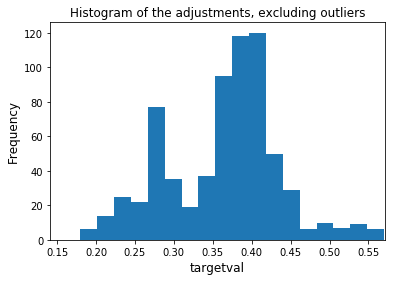

In [184]:
q1 = np.percentile(df['targetval'], 25)
q3 = np.percentile(df['targetval'], 75)
IQR = abs(q1-q3)

minlim = q1-(1.5*IQR)
maxlim = q3+(1.5*IQR)


mask = (minlim <= df['targetval']) & (df['targetval'] <=maxlim)
ax = df.loc[mask]['targetval'].hist(bins='fd',grid=False,)
ax.set_xlim(minlim,maxlim)
ax.set_xlabel("targetval",size='large')
ax.set_ylabel("Frequency",size='large')
ax.set_title("Histogram of the adjustments, excluding outliers",size='large')
f = ax.get_figure()
plt.plot()
f.savefig("tar-hist-zoom.pdf", bbox_inches='tight')

In [ ]:
mask = (df['targetval'] !=0)
q1 = np.percentile(df.loc[mask]['targetval'], 25)
q3 = np.percentile(df.loc[mask]['targetval'], 75)
IQR = abs(q1-q3)

minlim = q1-(1.5*IQR)
maxlim = q3+(1.5*IQR)


mask = (minlim <= df['targetval']) & (df['targetval'] <=maxlim)
ax = df.loc[mask]['targetval'].hist(bins='fd',grid=False,)
ax.set_xlim(minlim,maxlim)
ax.set_xlabel("targetval",size='large')
ax.set_ylabel("Frequency",size='large')
ax.set_title("Histogram of the adjustments, excluding outliers",size='large')
f = ax.get_figure()
plt.plot()
f.savefig("tar-hist-zoom-excl0.pdf", bbox_inches='tight')

In [188]:
df

,machine,prodid,adjustment,targetval,val,starttime,0,1,2,3,...,290,291,292,293,294,295,296,297,298,299
0,m21,9945,0.020,0.540,0.520,2018-12-04 04:25:43,592.815125,591.794617,595.602417,606.563354,...,1790.565918,1788.083496,1783.526733,1780.427246,1773.602051,1768.502075,1767.935303,1770.523560,1772.624023,1778.689697
1,m21,9945,0.010,0.520,0.510,2018-11-30 20:40:19,701.528198,709.587341,713.781921,722.543396,...,1731.326172,1728.975464,1727.023193,1726.315308,1724.901367,1724.786133,1725.746338,1729.077026,1733.856934,1736.765503
2,m21,9945,0.010,0.510,0.500,2018-11-29 01:29:17,607.899841,606.221619,605.999695,606.570679,...,1757.030762,1760.599487,1763.340576,1765.603027,1767.789307,1769.242676,1773.512939,1779.958496,1787.926025,1796.326294
3,m21,9945,0.010,0.500,0.490,2018-11-21 11:35:42,665.848755,655.410278,649.023926,637.917114,...,1731.382690,1730.123291,1728.766479,1728.005127,1727.681641,1727.692627,1728.848022,1731.632202,1736.013306,1741.925293
4,m21,9945,0.050,0.490,0.440,2018-11-13 08:37:40,632.212708,641.434509,653.968933,666.009827,...,1758.969482,1763.225220,1770.604858,1773.422363,1772.317871,1769.686279,1766.411255,1764.198730,1757.627441,1749.590332
5,m21,9945,0.060,0.530,0.470,2018-11-12 13:58:16,821.289124,815.909302,811.614929,809.596924,...,1831.338501,1828.398315,1824.820801,1821.406860,1819.663086,1815.492065,1809.154175,1801.697510,1795.672852,1793.697388
6,m21,9305,-0.010,0.610,0.620,2018-08-23 15:10:38,887.475525,890.554688,892.706116,898.171326,...,1418.445068,1418.187500,1418.335693,1418.507568,1418.695801,1418.842529,1419.211670,1419.386230,1419.503418,1419.656372
7,m21,9305,0.040,0.620,0.580,2018-08-23 10:48:54,872.302307,874.278076,877.841492,882.223694,...,1400.385132,1400.403564,1400.436035,1400.804199,1400.927368,1401.128662,1400.953857,1401.309204,1401.473755,1401.911987
8,m21,9305,0.030,0.580,0.550,2018-08-17 15:02:44,874.669250,875.488098,878.510132,882.386108,...,1378.355957,1378.374390,1378.382324,1378.382935,1378.565430,1378.809570,1378.946289,1379.373291,1379.720093,1379.997925
9,m21,9305,0.005,0.540,0.535,2018-08-14 06:45:32,884.907532,887.065063,890.313110,892.323608,...,1393.485107,1393.979858,1394.246216,1394.292114,1394.311279,1394.374146,1394.463745,1394.478149,1394.475342,1394.535889


In [15]:
df2 = pd.concat([df,pd.get_dummies(df[['machine','prodid']])],axis=1)

In [16]:
df2.to_csv('dataset-goldenref.csv')

In [203]:
df

,machine,prodid,adjustment,targetval,val,starttime,0,1,2,3,...,290,291,292,293,294,295,296,297,298,299
0,m21,9945,0.020,0.540,0.520,2018-12-04 04:25:43,592.815125,591.794617,595.602417,606.563354,...,1790.565918,1788.083496,1783.526733,1780.427246,1773.602051,1768.502075,1767.935303,1770.523560,1772.624023,1778.689697
1,m21,9945,0.010,0.520,0.510,2018-11-30 20:40:19,701.528198,709.587341,713.781921,722.543396,...,1731.326172,1728.975464,1727.023193,1726.315308,1724.901367,1724.786133,1725.746338,1729.077026,1733.856934,1736.765503
2,m21,9945,0.010,0.510,0.500,2018-11-29 01:29:17,607.899841,606.221619,605.999695,606.570679,...,1757.030762,1760.599487,1763.340576,1765.603027,1767.789307,1769.242676,1773.512939,1779.958496,1787.926025,1796.326294
3,m21,9945,0.010,0.500,0.490,2018-11-21 11:35:42,665.848755,655.410278,649.023926,637.917114,...,1731.382690,1730.123291,1728.766479,1728.005127,1727.681641,1727.692627,1728.848022,1731.632202,1736.013306,1741.925293
4,m21,9945,0.050,0.490,0.440,2018-11-13 08:37:40,632.212708,641.434509,653.968933,666.009827,...,1758.969482,1763.225220,1770.604858,1773.422363,1772.317871,1769.686279,1766.411255,1764.198730,1757.627441,1749.590332
5,m21,9945,0.060,0.530,0.470,2018-11-12 13:58:16,821.289124,815.909302,811.614929,809.596924,...,1831.338501,1828.398315,1824.820801,1821.406860,1819.663086,1815.492065,1809.154175,1801.697510,1795.672852,1793.697388
6,m21,9305,-0.010,0.610,0.620,2018-08-23 15:10:38,887.475525,890.554688,892.706116,898.171326,...,1418.445068,1418.187500,1418.335693,1418.507568,1418.695801,1418.842529,1419.211670,1419.386230,1419.503418,1419.656372
7,m21,9305,0.040,0.620,0.580,2018-08-23 10:48:54,872.302307,874.278076,877.841492,882.223694,...,1400.385132,1400.403564,1400.436035,1400.804199,1400.927368,1401.128662,1400.953857,1401.309204,1401.473755,1401.911987
8,m21,9305,0.030,0.580,0.550,2018-08-17 15:02:44,874.669250,875.488098,878.510132,882.386108,...,1378.355957,1378.374390,1378.382324,1378.382935,1378.565430,1378.809570,1378.946289,1379.373291,1379.720093,1379.997925
9,m21,9305,0.005,0.540,0.535,2018-08-14 06:45:32,884.907532,887.065063,890.313110,892.323608,...,1393.485107,1393.979858,1394.246216,1394.292114,1394.311279,1394.374146,1394.463745,1394.478149,1394.475342,1394.535889
